## <span style="color:blue">Problem statment

The content, tone, and format of job bulletins can influence the quality of the applicant pool. Overly-specific job requirements may discourage diversity. The Los Angeles Mayor’s Office wants to reimagine the city’s job bulletins by using text analysis to identify needed improvements.

The goal is to convert a folder full of plain-text job postings into a single structured CSV file and then to use this data to answer the questions provided below


## <span style="color:blue">Data Description

The job bulletins will be provided as a folder of plain-text files, one for each job classification.

Job Bulletins: 683 plain-text job postings

Instructions and Additional Documents:

- Job Bulletins with Annotations

- Annotation Descriptions.docx

- City Job Paths

- PDFs

- Description of promotions in job bulletins.docx

- Job_titles.csv

- Kaggle_data_dictionary.csv


### <span style="color:orange">Task 1

Create a descriptive csv file from the plain-text samples with the followoing columns:

- FILE_NAME: The bulletins file name.
- JOB_CLASS_TITLE: Job title.
- JOB_CLASS_NO: Job number.
- JOB_DUTIES: The duties of this job.
- EDUCATION_YEARS: Number of education yeras needed to apply for this job.
- SCHOOL_TYPE: The type of school you need to study in.
- EDUCATION_MAJOR: The eductaion major you study in this school.
- EXPERIENCE_LENGTH: The number of experience years needed to apply for this job .
- FULL_TIME_PART_TIME: If the job is full time or part time or both.
- EXP_JOB_CLASS_TITLE: The title of the job you must have experience in before applying in this job.
- COURSE_COUNT: Number of courses neede to apply for this job.
- COURSE_LENGTH: The course length in years or months.
- COURSE_SUBJECT: The course subject tha is needed to be accepted in this job.
- DRIVERS_LICENSE_REQ: Is driver license required or not for this job.
- EXAM_TYPE: Type of exams neededin the hiring process.
- ENTRY_SALARY: Salary range in this job.
- OPEN_DATE: Date at it the job bulliten got open.
- REQUIREMENT_SET_TEXT: The requirments set need for this job in points.

In [ ]:
import pandas as pd 
import numpy as np
import re
import os
from datetime import datetime
import matplotlib.pyplot as plt
import glob

path='Data/cityofla/CityofLA/Job Bulletins/*.txt'
jobs = []
names = []
files = glob.glob(path)
for file in files:
    with open(file, 'r') as f:
        lines = f.read()
        jobs.append(lines)
        names.append(os.path.basename(str(file.split('.')[0])))
df2 = pd.DataFrame({'Jobs':jobs})
df = pd.DataFrame({'FILE_NAME': names})

df2['Jobs'] = df2['Jobs'].apply(lambda x: x.lstrip())
df['JOB_CLASS_TITLE'] = df2['Jobs'].apply(lambda x: x.split('\n', 1)[0])
df['JOB_CLASS_TITLE'] = df['JOB_CLASS_TITLE'].apply(lambda x: x.replace("\n","").replace("\t","").strip())
df2 = df2['Jobs'].apply(lambda x: ' '.join(x.split()))

def class_code(text):
    match = re.search('Class Code: (\d+)', text)
    class_code = ''
    try:
        class_code = match.group(1)
    except:
        class_code = ''
    return class_code

df['JOB_CLASS_NO'] = df2.apply(lambda x: class_code(x))

def job_duties(text):
    duties = ''
    result = re.search("DUTIES(.*?)REQUIREMENT", text)
    if result:
        duties = result.group(1).strip()
    return duties

df['JOB_DUTIES'] = df2.apply(lambda x: job_duties(x))

def requirement_set(text):
    requirement = '|'.join(['REQUIREMENTS/MINIMUM QUALIFICATIONS', 
                  'REQUIREMENTS/ MINIMUM QUALIFICATIONS', 
                  'REQUIREMENTS/MINUMUM QUALIFICATIONS', 
                  'REQUIREMENT/MINIMUM QUALIFICATION', 
                  'REQUIREMENT/ MINIMUM QUALIFICATION', 
                  'REQUIREMENTS', 
                  'REQUIREMENT',
                  'MINIMUM REQUIREMENTS:'])
    
    result = re.search(f"({requirement})(.*)(WHERE TO APPLY|HOW TO APPLY)", text)
    reqs = ''
    if result:
        reqs = result.group(2).strip()
    return reqs

df['REQUIREMENT_SET_TEXT'] = df2.apply(lambda x: requirement_set(x))

ex_year=re.compile(r'(One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|one|two|three|four|five|six|seven|eight|nine)\s(years?)\s(of\sfull(-|\s)time)')
df['EXPERIENCE_LENGTH'] = df['REQUIREMENT_SET_TEXT'].apply(lambda x : re.search(ex_year,x).group(1) if re.search(ex_year,x) is not None else 'zero')

def school_type(text):
    school = ["university", "college", "high school", "apprenticeship"]
    SCHOOL_TYPE = []
    for word in school:
        if word in str(text):
            SCHOOL_TYPE.append(word)
    return SCHOOL_TYPE
df['SCHOOL TYPE'] = df2.apply(lambda x: school_type(x))

edu_year = re.compile(r'(One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|one|two|three|four|five|six|seven|eight|nine)(\s|-)(years?)\s(college|university)')
df['EDUCATION_YEARS'] = df['REQUIREMENT_SET_TEXT'].apply(lambda x : re.search(edu_year,x).group(1) if re.search(edu_year,x) is not None else 'zero')

def license(text):
    driver_license = []
    if "driver's license is required" in str(text) or "may require a valid California driver's license" in str(text):
        driver_license.append(1)
    else:
        driver_license.append(0)
    return driver_license

df['DRIVER LICENSE'] = df2.apply(lambda x: license(x))

def fullPart(text):
    full = ["full-time", "part-time", "full time", "part time"]
    FULL_PART = []
    for word in full:
        if word in str(text):
            FULL_PART.append(word)
    return FULL_PART
df['FULL_TIME_PART_TIME'] = df2.apply(lambda x: fullPart(x)) 

def exam_type(text):
    exam = ["Written Test","Interview","Questionnaire","Essay"]
    EXAM_TYPE = []
    for word in exam:
        if word in str(text):
            EXAM_TYPE.append(word)
    return EXAM_TYPE
df['EXAM TYPE'] = df2.apply(lambda x: exam_type(x))

def salary(text):
    salary = re.compile(r'\$(\d+,\d+)((\s(to|and)\s)(\$\d+,\d+))?')
    sal = re.search(salary,text)
    salary_text = ''
    if sal:
        salary_text = (str(sal.group(1)) + '-' + str(sal.group(5))).replace('$', '')
    return salary_text
    
df['ENTRY_SALARY'] = df2.apply(lambda x: salary(x))

def open_date(text):             
    open_date = re.compile(r'(Open [D,d]ate:)(\s+)(\d\d-\d\d-\d\d)') 
    res = re.search(open_date,text)
    date = ''
    if res:
        date = datetime.strptime(res.group(3),'%m-%d-%y')
    return date

df['OPEN_DATE'] = df2.apply(lambda x: open_date(x))

for i in range(0,len(df)):
    df['SCHOOL TYPE'][i] = str(df['SCHOOL TYPE'][i]).replace("[","").replace("]","").replace("'","")
    df['DRIVER LICENSE'][i] = str(df['DRIVER LICENSE'][i]).replace("[","").replace("]","").replace("'","")
    df['EXAM TYPE'][i] = str(df['EXAM TYPE'][i]).replace("[","").replace("]","").replace("'","")
    df['FULL_TIME_PART_TIME'][i] = str(df['FULL_TIME_PART_TIME'][i]).replace("[","").replace("]","").replace("'","")
    
df = df.replace(r'^\s*$', np.nan, regex=True)

df.head()   

<ipython-input-1-36950edc3eae>:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SCHOOL TYPE'][i] = str(df['SCHOOL TYPE'][i]).replace("[","").replace("]","").replace("'","")
<ipython-input-1-36950edc3eae>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRIVER LICENSE'][i] = str(df['DRIVER LICENSE'][i]).replace("[","").replace("]","").replace("'","")
<ipython-input-1-36950edc3eae>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,JOB_DUTIES,REQUIREMENT_SET_TEXT,EXPERIENCE_LENGTH,SCHOOL TYPE,EDUCATION_YEARS,DRIVER LICENSE,FULL_TIME_PART_TIME,EXAM TYPE,ENTRY_SALARY,OPEN_DATE
0,311 DIRECTOR 9206 041814,311 DIRECTOR,9206,A 311 Director is responsible for the successf...,1. One year of full-time paid experience as a ...,One,"university, college",zero,0,"full-time, part-time","Interview, Questionnaire","125,175-155,514",2014-04-18
1,ACCOUNTANT 1513 062218,ACCOUNTANT,1513,An Accountant does professional accounting wor...,Graduation from an accredited four-year colleg...,zero,"university, college",four,1,NaN,"Written Test, Interview","49,903-72,996",2018-06-22
2,ACCOUNTING CLERK 1223 071318,ACCOUNTING CLERK,1223,An Accounting Clerk performs difficult and res...,Two years of full-time paid office clerical ex...,Two,"university, college",zero,0,"full-time, part-time",NaN,"49,005-71,618",2018-07-13
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718,ACCOUNTING RECORDS SUPERVISOR,1119,"An Accounting Records Supervisor assigns, revi...",Two years of full-time paid experience as an A...,Two,NaN,zero,0,full-time,Interview,"55,332-80,930",2018-07-27
4,ADMINISTRATIVE ANALYST 1590 060118,ADMINISTRATIVE ANALYST,1590,An Administrative Analyst performs professiona...,1. One year of full-time paid professional exp...,One,"university, college",four,1,full-time,"Written Test, Interview, Questionnaire, Essay","60,489-88,468",2018-06-01


### <span style="color:orange">Task 2

Assume you are a DA in a company and you are about to prepare a report to the LA governate about there jobs, by answering some questions and give insight about the data provided.

### Note: This section will be a QA cells.

### <span style="color:brown">Q1:

A non-experienced job seeker wants to know what is the best job for him?

In [ ]:
### Write you code here ###
NonExp = df[df['EXPERIENCE_LENGTH'] == 'zero']
NonExp['JOB_CLASS_TITLE']

1                                       ACCOUNTANT
5                             ADMINISTRATIVE CLERK
7      ADVANCE PRACTICE PROVIDER CORRECTIONAL CARE
13                                   AIRPORT GUIDE
14                  AIRPORT INFORMATION SPECIALIST
                          ...                     
657                                WATER BIOLOGIST
658                           WATER MICROBIOLOGIST
663                       WATER TREATMENT OPERATOR
669                           WATER UTILITY WORKER
679                X-Ray and Laboratory Technician
Name: JOB_CLASS_TITLE, Length: 92, dtype: object

### <span style="color:brown">Q2:

A concerned parents contacts you to tell them if there is a spicific school type that would guaranteed for their child a good future if you can tell, and which is it ?

Text(0.5, 1.0, 'School Types')

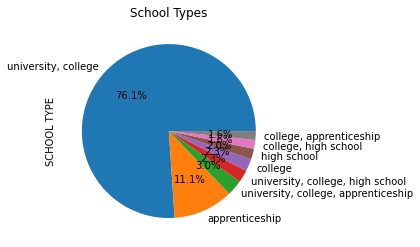

In [ ]:
### Write you code here ###

SchType = df['SCHOOL TYPE'].dropna()
fig, ax = plt.subplots() 
SchType.value_counts().plot.pie(autopct="%.1f%%");
ax.set_title('School Types')

### <span style="color:brown">Q3:

What the best time in the year to be ready for a job applying in any experience level?

<AxesSubplot:>

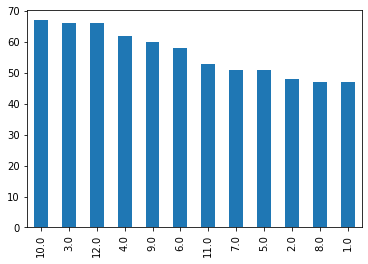

In [ ]:
### Write you code here ###
df['month'] = pd.DatetimeIndex(df['OPEN_DATE']).month
data = df["month"].value_counts()
data.plot(kind = 'bar')

### <span style="color:brown">Q4:

Is experience more important than educational level?

<BarContainer object of 2 artists>

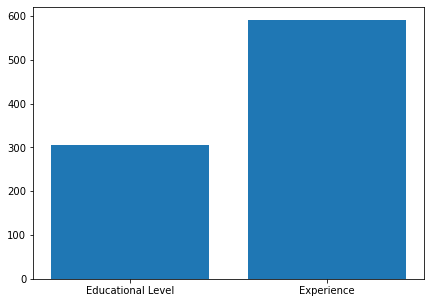

In [ ]:
### Write you code here ###

expl = df.drop(df[df.EXPERIENCE_LENGTH == 'zero'].index)

x1= len(SchType)
x2=len(expl['EXPERIENCE_LENGTH'])

plt.figure(figsize=(7,5))
plt.bar(height=[x1,x2],x=['Educational Level','Experience'])

### <span style="color:brown">Q5:

Which fresh grade job that will guarantee many job offers in the future for him?

In [ ]:
### Write you code here ###

### <span style="color:brown">Q6:

"The City of Los Angeles does not discriminate on the basis of race, religion, national origin, sex, age, marital status, sexual orientation, gender identity, gender expression, disability, creed, color, ancestry, medical condition (cancer), or Acquired Immune Deficiency Syndrome.

AN EQUAL EMPLOYMENT OPPORTUNITY EMPLOYER 
"

The above statment is qouted from one of the job descriptions.

Based on the jobs requirments you structred above do you think that LA governate may bais a little for men over women or the applicant marital status for example may effect his chance to gain the job?

In [ ]:
### Write you code here ###
bias_list = ["male", "female", "man", "men", "woman", "women", "married", "single"]
words = []
for word in df['REQUIREMENT_SET_TEXT']:
    if word in bias_list:
        words.append[word]
if len(words) == 0:
    print("Not biased")

Not biased


### <span style="color:brown">Q7:

The city need an advice based on your analysis, build a new schools for more fresh non-experienced workers or encorge the work environment to help the workers to get promotions?

Since most of the jobs require more experience years for applying, I think it is better to encorage the work environment to help the workers to get promotions.


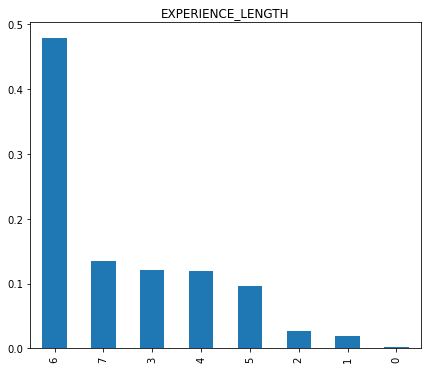

In [ ]:
### Write you code here ###
df["EXPERIENCE_LENGTH"].replace("One", "one", inplace = True)
df["EXPERIENCE_LENGTH"].replace("Two", "two", inplace = True)
df["EXPERIENCE_LENGTH"].replace("Three", "three", inplace = True)
df["EXPERIENCE_LENGTH"].replace("Four", "four", inplace = True)
df["EXPERIENCE_LENGTH"].replace("Five", "five", inplace = True)

from sklearn import preprocessing 
label = preprocessing.LabelEncoder() 
 
df["EXPERIENCE_LENGTH"]= label.fit_transform(df["EXPERIENCE_LENGTH"]) 
df["EXPERIENCE_LENGTH"].value_counts(normalize= True).plot.bar(figsize = (7,6),title="EXPERIENCE_LENGTH")

print("Since most of the jobs require more experience years for applying, I think it is better to encorage the work environment to help the workers to get promotions.")

### <span style="color:brown">Q8:

What is the average salary for worker with a driver licence?

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


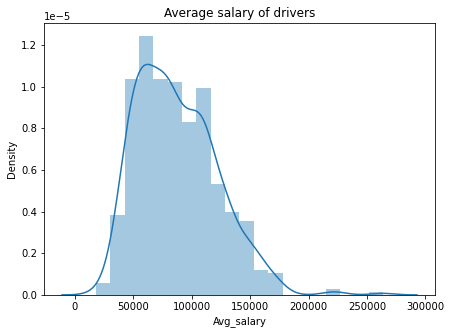

In [ ]:
### Write you code here ###
df['ENTRY_SALARY'].fillna(df['ENTRY_SALARY'].mode()[0], inplace=True)
df['ENTRY_SALARY'].isna().sum()
sal_list = []
avg_sal = []
for i in df['ENTRY_SALARY']:
    sal_list.append(i)
for j in sal_list:
    j = j.replace('None', j[0])
    j = j.replace(',', '')
    j = j.split('-')
    avg_sal.append((int(j[0]) + int(j[1])) / len(j))

df['Avg_salary'] = pd.Series(avg_sal)

import seaborn as sns

drive = df[df['DRIVER LICENSE'] == '1']

plt.figure(figsize=(7,5))
sns.distplot(drive['Avg_salary'])
plt.title('Average salary of drivers')
plt.show()

## <span style="color:brown">Q9:

list the most feature that effect the salary of the worker.

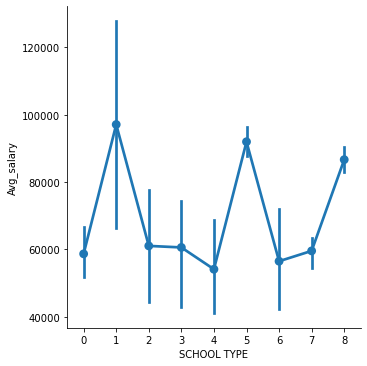

In [ ]:
### Write you code here ###
dfx = df.sort_values(by=["EXPERIENCE_LENGTH"])
#print(dfx["EXPERIENCE_LENGTH"].unique())
df["SCHOOL TYPE"]= label.fit_transform(df["SCHOOL TYPE"]) 
dfs = df.sort_values(by=["SCHOOL TYPE"])

sns.catplot(x="SCHOOL TYPE", y="Avg_salary",
            kind="point", data=dfs)


## <span style="color:brown">Q10:

Give a full statistical description for all numrical data columns including all insights and needed figures to visualize them.

       EXPERIENCE_LENGTH       month     Avg_salary
count         683.000000  676.000000     683.000000
mean            5.215227    6.671598   85842.942899
std             1.481737    3.460485   35231.669083
min             0.000000    1.000000   17906.000000
25%             4.000000    4.000000   57560.500000
50%             6.000000    7.000000   80241.500000
75%             6.000000   10.000000  108189.250000
max             7.000000   12.000000  263610.000000


C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


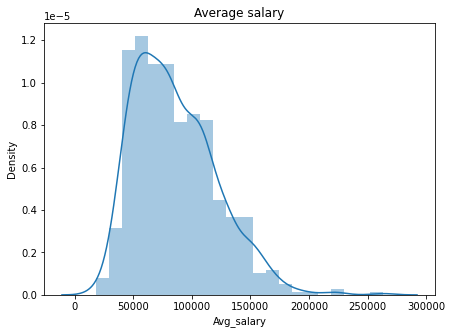

In [ ]:
### Write you code here ###
print(df.describe())

plt.figure(figsize=(7,5))
sns.distplot(df['Avg_salary'])
plt.title('Average salary')
plt.show()


## <span style="color:brown">Q11:

Give a full statistical description for the categorical data columns that can be descriped including all insights and needed figures to visualize them.


<ipython-input-12-f08f7e8fa171>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(13)+str(cat_cols.index(col)+1))
<ipython-input-12-f08f7e8fa171>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(13)+str(cat_cols.index(col)+1))
<ipython-input-12-f08f7e8fa171>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(13)+str(cat_cols.index(col)+1))
<ipython-input-12-f08f7e8fa171>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(13)+str(cat_cols.index(col)+1))
<ipython-input-

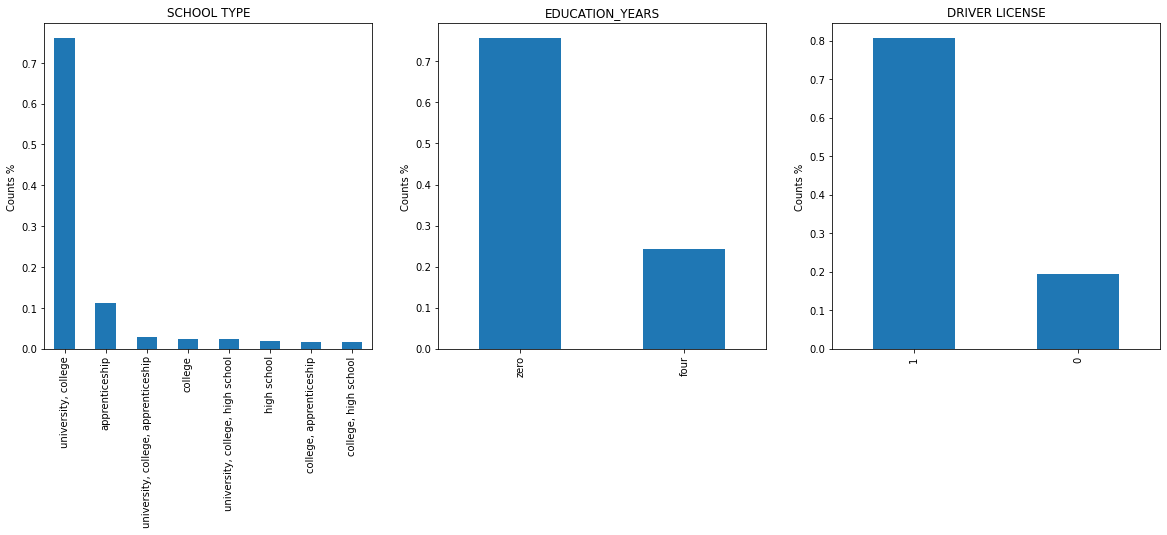

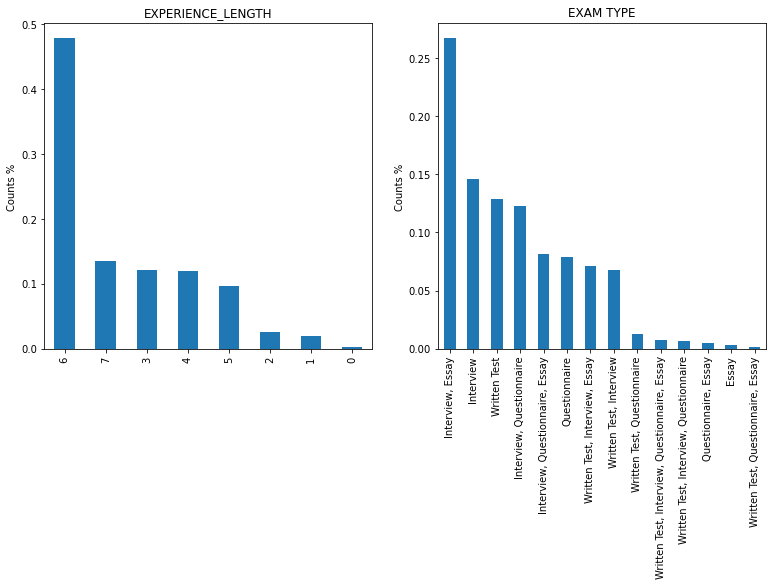

In [ ]:
### Write you code here ###

plt.figure(1)
cat_cols = ['SCHOOL TYPE','EDUCATION_YEARS', 'DRIVER LICENSE']

for col in cat_cols:
    plt.subplot(str(13)+str(cat_cols.index(col)+1))
    df[col].value_counts(normalize= True).plot.bar(figsize = (20,6),title=col)
    plt.ylabel("Counts % ");
    


plt.figure(2)
cat_cols = ['EXPERIENCE_LENGTH', 'EXAM TYPE']

for col in cat_cols:
    plt.subplot(str(13)+str(cat_cols.index(col)+1))
    df[col].value_counts(normalize= True).plot.bar(figsize = (20,6),title=col)
    plt.ylabel("Counts % ");

## Great Job.